<a href="https://colab.research.google.com/github/JanNogga/Vision_Systems_Lab/blob/main/Assignment_7/CelebA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Addendum - CelebA

This notebook is the same as the other one, but evaluates the slightly modified model (just to accommodate the resolution) and training procedure on the CelebA dataset. We think this might be interesting because for CIFAR10, the output of a trained generator is not easy to judge visually. To us, it seems like a CIFAR10 image is essentially some blurry patch  in the center and then a textured background around it. For fake images of faces generated at reasonable resolution, the human eye is probably an extremely good critic.

In [18]:
import numpy as np
import random as rand
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import os
import time
from tqdm.notebook import tqdm
import shutil

from torch.utils.tensorboard import SummaryWriter

In [19]:
GAN_LOGS = os.path.join(os.getcwd(), "tboard_logs", "gan")
if not os.path.exists(GAN_LOGS):
    os.makedirs(GAN_LOGS)
  
shutil.rmtree(GAN_LOGS)
writer = SummaryWriter(GAN_LOGS)

### Tensorboard logging

This notebook can be opened in Colab, where a TensorBoard session opens in the cell below. It has the training process logs fully cached, so they can be explored there. 

Note that the discrimator loss term seems to converge toward (not quite), which actually corresponds very well to the improvement in image quality during training. This behaviour is described in the [wgan paper](https://arxiv.org/pdf/1701.07875.pdf) too, but they plot the same loss with flipped sign, so our plot is not entirely the same. Nevertheless, we are quite happy that this could be replicated.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir $GAN_LOGS

In [21]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop((192,160)),
    transforms.Resize((96,80)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Note the cells at the end of the notebook
# They are executed first to prepare this line
trainset = dsets.CelebA('data', split='all', download=False, transform=data_transforms)

BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) 

NUM_CHANNELS = 3
Z_DIM = 96
CD = 54
CG = 64

In [22]:
if not os.path.exists("imgs"):
    os.makedirs("imgs")
try:
  shutil.rmtree("imgs/training")
except:
  pass
if not os.path.exists("imgs/training"):
    os.makedirs("imgs/training")

### Models

#### Generator

The generator is very similar to the decoder we previously used. LeakyReLU enjoys high popularity for generator within GANs, so we replaced ReLU with that. Based on the feedback for the previous assignment, and our improved results using upsampling into convolution layers there, we use *nn.Upsample()* instead of transposed convolutions.

In [23]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
      
    def forward(self, x):
        return x.view(-1, *self.shape)

class Generator(nn.Module):
    def __init__(self, z_dim, cc=CG):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # input is Z
            nn.Linear(z_dim, cc*16*6*5, bias=False),
            Reshape((cc*16,6,5)),
            # state size: (cc*16) x 6 x 5
            nn.Upsample(scale_factor=2),
            nn.Conv2d(cc*16, cc*8, 5, padding='same', bias=False),
            nn.BatchNorm2d(cc * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (cc*8) x 12 x 10
            nn.Upsample(scale_factor=2),
            nn.Conv2d(cc*8, cc*4, 5, padding='same', bias=False),
            nn.BatchNorm2d(cc * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (cc*4) x 24 x 20
            nn.Upsample(scale_factor=2),
            nn.Conv2d(cc*4, cc*2, 5, padding='same', bias=False),
            nn.BatchNorm2d(cc * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (cc*2) x 48 x 40
            nn.Upsample(scale_factor=2),
            nn.Conv2d(cc*2, NUM_CHANNELS, 5, padding='same', bias=False),
            nn.BatchNorm2d(NUM_CHANNELS),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(NUM_CHANNELS, NUM_CHANNELS, 5, padding='same', bias=False),
            nn.Tanh()
            # state size: C x 96 x 80
        )

    def forward(self, input):
        return self.model(input)

#### Discriminator

The discriminator is nothing special, but we removed the previous *nn.BatchNorm2d()* because it violates the conditions for [wgan-gp](https://arxiv.org/pdf/1704.00028.pdf). It seems unadvisable to place a strided convolution in it's first layer as per [this article](https://distill.pub/2016/deconv-checkerboard/) (there is a figure showing this right before the conclusion) so we started downsampling only in the second layer. We saw some examples which used a convolution onto $1 \times 1$ feature maps in the final layer (basically a fully connected layer as well), but decided against it so we could better apply dropout. 

In [24]:
class Discriminator(nn.Module):
    def __init__(self, cc=CD):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # input is C x 96 x 80
            nn.Conv2d(NUM_CHANNELS, cc, kernel_size=5, bias=False, padding='same'),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (cc) x 96 x 80
            nn.Conv2d(cc, cc*2, 5, 2, 2, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (cc*2) x 48 x 40
            nn.Conv2d(cc*2, cc*2, 5, 2, 2, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (cc*2) x 24 x 20
            nn.Conv2d(cc*2, cc*4, 5, 2, 2, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (cc*4) x 12 x 10
            nn.Conv2d(cc*4, cc*4, 5, 2, 2, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (cc*4) x 6 x 5
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(cc*4*6*5, 1, bias=False)
        )

    def forward(self, input):
        return self.model(input)

#### Training

The overall class is of course taken from lab session 7, which should be quite evident. We started out at first using a DCGAN with the losses originally in this trainer, but, while it worked without any problems for FMNIST, but beyond that sanity check, we were unable to produce results for CIFAR.

We then switched to a WGAN training scheme, adding the innermost loop over *n_critic* batches to train the discriminator for each time we improve the generator. This is not implemented as an extra loop, but implicitly via *self.d_train_step*, a boolean which is flipped using *self.d_train_step_counter*. In the context of WGAN, we also removed the sigmoid activation at the discriminator output and allowed negative losses. Basically, the discriminator is now trying to seperate fake and real samples by assigning large positive values to one and large negative values to the other. It is thereby more a critic than a discriminator. However, the loss frequently exploded, which we chalked up to the clipping parameter *c*, which we feel is very difficult to tune for WGAN.

Hoping to get away from this hyperparameter, we added a gradient penalty loss which enforces the Lipschitz criterion described in WGAN. This was implemented according to [the code here](https://github.com/EmilienDupont/wgan-gp/blob/master/training.py), only little adaption from the outdated PyTorch versions used there was necessary. Also, since it is suggested for WGAN-GP, we switched the optimizer back to Adam and adjusted the learning rate to be a little higher than for WGAN.

In [25]:
class Trainer:
    """
    Class for initializing GAN and training it
    """
    def __init__(self, latent_dim=128, writer=None):
        """ Initialzer """
        assert writer is not None, f"Tensorboard writer not set..."
        
        self.latent_dim = latent_dim
        self.writer = writer 
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        generator = Generator(z_dim=latent_dim)
        discriminator = Discriminator()
        self.generator = generator.to(self.device)
        self.discriminator = discriminator.to(self.device)
        
        self.optim_discriminator = torch.optim.Adam(self.discriminator.parameters(), lr=1e-4, betas=(0., 0.9))
        self.optim_generator = torch.optim.Adam(self.generator.parameters(), lr=1e-4, betas=(0., 0.9))
        
        self.criterion_d_real = lambda pred: pred.mean()
        self.criterion_d_fake = lambda pred: pred.mean()
        self.criterion_g = lambda pred: pred.mean()

        self.d_train_step_counter = 0
        self.d_train_step = True
        self.n_critic = 5
        #self.c = 1e-2
        self.lambda_gp = 10
        
        self.hist = {
            "d_real": [],
            "d_fake": [],
            "g": []
        }
        return
        
    def train_one_step(self, imgs):
        """ Training both models for one optimization step """
        
        self.generator.train()
        self.discriminator.train()
        
        # Sample from the latent distribution
        B = imgs.shape[0]
        latent = torch.randn(B, self.latent_dim).to(self.device)
        
        # ==== Training Discriminator ====
        self.optim_discriminator.zero_grad()
        # Get discriminator outputs for the real samples
        prediction_real = self.discriminator(imgs)
        # Compute the loss function
        d_loss_real = self.criterion_d_real(prediction_real)

        # Generating fake samples with the generator
        fake_samples = self.generator(latent)
        # Get discriminator outputs for the fake samples
        prediction_fake_d = self.discriminator(fake_samples.detach())
        # Compute the loss function
        d_loss_fake = self.criterion_d_fake(prediction_fake_d)
        grad_loss = self.gradient_loss(imgs, fake_samples.detach())
        if self.d_train_step_counter >= self.n_critic:
          self.d_train_step = False
          self.d_train_step_counter = 0
        if self.d_train_step:
          (d_loss_fake - d_loss_real + grad_loss).backward()
          self.d_train_step_counter += 1
          # optimization step
          #torch.nn.utils.clip_grad_value_(self.discriminator.parameters(), self.c)
          self.optim_discriminator.step()
      
        # === Train the generator ===
        self.optim_generator.zero_grad()
        # Get discriminator outputs for the fake samples
        prediction_fake_g = self.discriminator(fake_samples)
        # Compute the loss function
        g_loss = -self.criterion_g(prediction_fake_g)
        if not self.d_train_step:
          g_loss.backward()
          # optimization step
          self.optim_generator.step()
          self.d_train_step = True
        
        return d_loss_fake - d_loss_real + grad_loss, g_loss

    def gradient_loss(self, real_samples, fake_samples):    
        B = real_samples.shape[0]
        # Calculate interpolation
        eps = torch.rand(B, 1, 1, 1)
        eps = eps.expand_as(real_samples).to(self.device)
   
        interpolated = eps * real_samples + (1 - eps) * fake_samples
        interpolated.requires_grad = True

        pred_interpolated = self.discriminator(interpolated)

        gradients = torch.autograd.grad(outputs=pred_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones_like(pred_interpolated),
                               create_graph=True)[0]

        # Gradients have shape (batch_size, num_channels, img_width, img_height),
        # so flatten to easily take norm per example in batch
        gradients = gradients.view(B, -1)

        # Derivatives of the gradient close to 0 can cause problems because of
        # the square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Return gradient penalty
        return self.lambda_gp * ((gradients_norm - 1) ** 2).mean()
    
    @torch.no_grad()
    def generate(self, N=64):
        """ Generating a bunch of images using current state of generator """
        self.generator.eval()
        latent = torch.randn(N, self.latent_dim).to(self.device)
        samples = self.generator(latent)
        imgs = samples # vector_to_image(samples)
        imgs = imgs * 0.5 + 0.5
        return imgs
        
    def train(self, data_loader, N_iters=100, init_step=0):
        """ Training the models for several iterations """
        
        progress_bar = tqdm(total=N_iters, initial=init_step)
        running_d_loss = 0
        running_g_loss = 0
        
        iter_ = 0
        for i in range(N_iters):
            for real_batch, _ in data_loader:              
                real_samples = real_batch
                real_samples = real_samples.to(self.device)
                d_loss, g_loss = self.train_one_step(imgs=real_samples)

                # updating progress bar
                progress_bar.set_description(f"Ep {i+1} Iter {iter_}: D_Loss={round(d_loss.item(),5)}, G_Loss={round(g_loss.item(),5)})")
                
                # adding stuff to tensorboard
                self.writer.add_scalar(f'Loss/Discriminator Loss', d_loss.item(), global_step=iter_)
                self.writer.add_scalar(f'Loss/Generator Loss', g_loss.item(), global_step=iter_)
                self.writer.add_scalars(f'Comb_Loss/Losses', {
                            'Discriminator': d_loss.item(),
                            'Generator':  g_loss.item(),
                        }, iter_)
                if(iter_ % 500 == 0):
                    imgs = self.generate()
                    grid = torchvision.utils.make_grid(imgs, nrow=8)
                    self.writer.add_image('images', grid, global_step=iter_)
                    torchvision.utils.save_image(grid, os.path.join(os.getcwd(), "imgs", "training", f"imgs_{iter_}.png"))

                iter_ = iter_ + 1 
                
        return

In [26]:
trainer = Trainer(latent_dim=Z_DIM, writer=writer)

In [27]:
trainer.train(data_loader=train_loader)

### Conclusion

Overall, training our DCGAN proved difficult with the vanilla training scheme as well as the WGAN training algorithm. However, switching to WGAN-GP seemed to do the trick, improving on the training stability for MNIST, FMNIST and CIFAR. Here, we can get okay results for different hyperparamter choices quite consistantly. We upload the animation created below to the repository along with the full image and loss logs for TensorBoard, in case those are not available above.

In [28]:
import imageio

images = []
img_path = os.path.join(os.getcwd(), "imgs", "training")

# making list with images and sorting by iteration
img_list = [img for img in os.listdir(img_path) if "imgs_" in img]
sorted_imgs = sorted(img_list, key=lambda x: int(x.split("_")[1].split(".")[0]))

In [29]:
for img in sorted_imgs:
    images.append(imageio.imread(os.path.join(img_path, img)))
imageio.mimsave(os.path.join(img_path, f"CELEBA_G{CG}_D{CD}_Z{Z_DIM}.gif"), images)

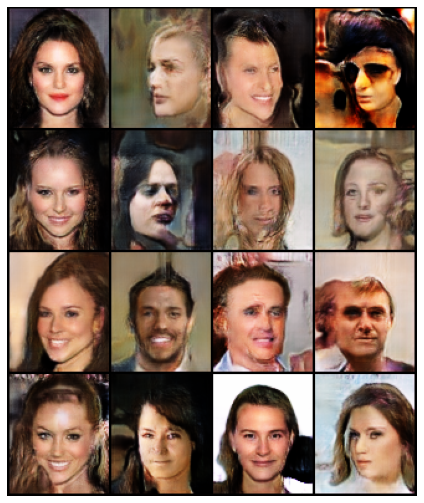

In [37]:
imgs = trainer.generate(N=16)
grid = torchvision.utils.make_grid(imgs, nrow=4)
plt.figure(figsize=(9,9))
plt.imshow(grid.permute(1,2,0).cpu())
plt.axis("off")
plt.show()

In [ ]:
!zip -r imgs.zip imgs/

  adding: imgs/ (stored 0%)
  adding: imgs/training/ (stored 0%)
  adding: imgs/training/imgs_63500.png (deflated 0%)
  adding: imgs/training/imgs_16500.png (deflated 0%)
  adding: imgs/training/imgs_26500.png (deflated 0%)
  adding: imgs/training/imgs_62500.png (deflated 0%)
  adding: imgs/training/imgs_11000.png (deflated 0%)
  adding: imgs/training/imgs_40500.png (deflated 0%)
  adding: imgs/training/imgs_19000.png (deflated 0%)
  adding: imgs/training/imgs_11500.png (deflated 0%)
  adding: imgs/training/imgs_500.png (deflated 0%)
  adding: imgs/training/imgs_49000.png (deflated 0%)
  adding: imgs/training/imgs_53500.png (deflated 0%)
  adding: imgs/training/imgs_18000.png (deflated 0%)
  adding: imgs/training/imgs_36500.png (deflated 0%)
  adding: imgs/training/imgs_10000.png (deflated 0%)
  adding: imgs/training/imgs_64500.png (deflated 0%)
  adding: imgs/training/imgs_57000.png (deflated 0%)
  adding: imgs/training/imgs_29500.png (deflated 0%)
  adding: imgs/training/imgs_74000.p

In [ ]:
!zip -r tboard_logs.zip tboard_logs/

  adding: tboard_logs/ (stored 0%)
  adding: tboard_logs/gan/ (stored 0%)
  adding: tboard_logs/gan/Comb_Loss_Losses_Generator/ (stored 0%)
  adding: tboard_logs/gan/Comb_Loss_Losses_Generator/events.out.tfevents.1626180505.7b805b18e15f.61.35 (deflated 70%)
  adding: tboard_logs/gan/events.out.tfevents.1626180503.7b805b18e15f.61.33 (deflated 22%)
  adding: tboard_logs/gan/Comb_Loss_Losses_Discriminator/ (stored 0%)
  adding: tboard_logs/gan/Comb_Loss_Losses_Discriminator/events.out.tfevents.1626180505.7b805b18e15f.61.34 (deflated 71%)


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
if not os.path.exists('data'):
    os.makedirs('data')
try:
  shutil.rmtree('data/celeba')
except:
  pass

In [7]:
print('Extracting files...')
!unzip /content/gdrive/MyDrive/celeba.zip -d data &> /dev/null
print('Done')

Extracting files...
Done
